<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-09/what_make_people_change_behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ins>In our research journey we found that people in some counties with shelter in place did not change their behavior that much during COVID. While other counties change behavior a lot. We want to see what makes that difference.</ins> Why do people in some counties change their behavior so drastically and some other counties not so much? (all with shelter in place policy).

For example, % of completely stay at home devices in King County increases by 15% during COVID, and LA county increases by 11%. However, some other counties only increases by 1% or didn't increase at all.

To see which variables affects % stay at home devices the most, we decide to use 4 approaches: linear regression, pearson correlation, mutual information, and feature importance factors from random forest models.
- Linear regression + pearson correlatoin only measures linear relationship
- mutual information and random forest measure non-linear relationship between variables.

*Data used here use a time window from shelter in place date to 6/1, and use shetler in place date as the baseline date, not first case date. The counties without shelter in place uses mean shelter in place date.*

# 1. load data and explore distribution of behavior change

In [1]:
cd drive/My\ Drive/fall

/content/drive/My Drive/fall


In [2]:
ls

county_data_with_covariates.csv
county_data_with_reduced_covariates_more_variables.csv
county_data_with_reduced_covariates_with_SIP.csv
county_data_with_reduced_covariates_with_SIP_up_to_5.csv
county_data_with_reduced_covariates_with_SIP_up_to_8.csv
mutual_information.ipynb
PSM_new.ipynb


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('county_data_with_reduced_covariates_with_SIP.csv')

In [8]:
data.head()

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9


In [9]:
data[data['cnamelong'] == 'King County']

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
2825,53.0,WA,Washington,King County,53033.0,0.154735,1,94822.0,3.2,2233163,0.504344,20.3,13.2,19.2,6.6,9.8,58.9


In [10]:
data[data['cnamelong'] == 'Los Angeles County']

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
189,6.0,CA,California,Los Angeles County,6037.0,0.118096,1,67986.0,0.6,10105518,0.480185,21.7,13.6,15.4,8.0,48.6,26.1


In [11]:
data[(data['SIP?'] == 1) & (data['diff_in_perc_at_home'] <= 0.05)]

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9
5,1.0,AL,Alabama,Bullock County,1011.0,-0.009576,1,29267.0,51.4,10138,0.508615,21.1,16.4,0.2,69.5,8.0,21.2
6,1.0,AL,Alabama,Butler County,1013.0,0.015350,1,37365.0,71.2,19680,-0.135291,22.2,20.3,1.3,44.6,1.5,51.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,55.0,WI,Wisconsin,Walworth County,55127.0,0.044673,1,64234.0,34.2,103718,-0.200554,20.6,17.7,1.1,1.0,11.2,85.3
2967,55.0,WI,Wisconsin,Washburn County,55129.0,0.026355,1,50482.0,83.2,15878,-0.234132,19.2,26.3,0.6,0.3,1.9,94.1
2970,55.0,WI,Wisconsin,Waupaca County,55135.0,0.018980,1,58648.0,64.9,51128,-0.302460,20.3,20.9,0.6,0.5,3.3,94.1
2971,55.0,WI,Wisconsin,Waushara County,55137.0,-0.019303,1,52340.0,89.5,24263,-0.323301,18.3,24.4,0.6,2.0,6.3,89.6


Let's see the distribution of increase of % of completely stay at home for both shelter in place counties and those without shelter in place.

Text(0.5, 1.0, 'Histogram of behavior change of % stay at home')

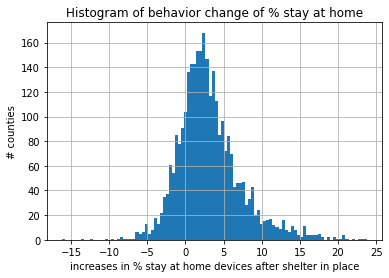

In [26]:
(100 * data['diff_in_perc_at_home']).hist(bins = 100)
plt.xlabel('increases in % stay at home devices after shelter in place')
plt.ylabel('# counties')
plt.title('Histogram of behavior change of % stay at home')

In [32]:
data['diff_in_perc_at_home'].describe()

count    2996.000000
mean        0.030979
std         0.041936
min        -0.161271
25%         0.005062
50%         0.025215
75%         0.050288
max         0.237698
Name: diff_in_perc_at_home, dtype: float64

Text(0.5, 1.0, 'Histogram of behavior change of % stay at home for counties with shelter in place')

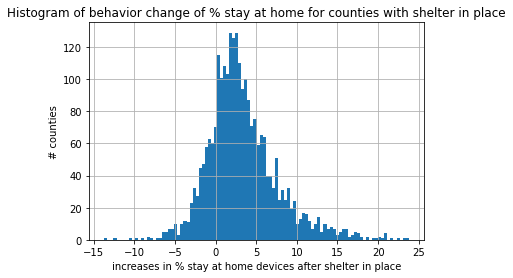

In [30]:
(100 * data[data['SIP?'] == 1]['diff_in_perc_at_home']).hist(bins = 100)
plt.xlabel('increases in % stay at home devices after shelter in place')
plt.ylabel('# counties')
plt.title('Histogram of behavior change of % stay at home for counties with shelter in place')

In [34]:
data[data['SIP?'] == 1]['diff_in_perc_at_home'].describe()

count    2549.000000
mean        0.033213
std         0.043462
min        -0.137045
25%         0.006223
50%         0.026382
75%         0.053763
max         0.237698
Name: diff_in_perc_at_home, dtype: float64

Text(0.5, 1.0, 'Histogram of behavior change of % stay at home for counties without shelter in place')

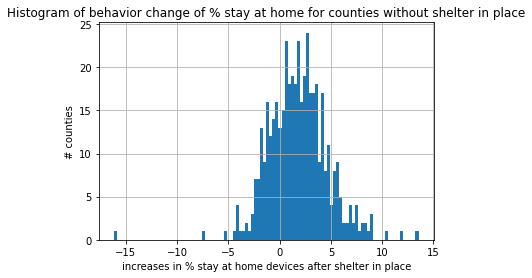

In [29]:
(100 * data[data['SIP?'] == 0]['diff_in_perc_at_home']).hist(bins = 100)
plt.xlabel('increases in % stay at home devices after shelter in place')
plt.ylabel('# counties')
plt.title('Histogram of behavior change of % stay at home for counties without shelter in place')

In [35]:
data[data['SIP?'] == 0]['diff_in_perc_at_home'].describe()

count    447.000000
mean       0.018239
std        0.028763
min       -0.161271
25%       -0.000778
50%        0.017603
75%        0.034900
max        0.135424
Name: diff_in_perc_at_home, dtype: float64

In [36]:
0.287 / 0.4346

0.660377358490566

As we can see, the distribution of behavior change as a whole looks pretty normal.

the distribution of behavior change for counties **with** shelter in place almost looks identitcal to the aggregate distribution. 

the distribution of behavior change for counties **without** shelter in place looks bit normal, but with less standard deviation. (has $66\%$ of the standard deviation as the with shelter in place distribution)

In [31]:
length = len(data[data['SIP?'] == 1])
print(f'There are {length} counties with shelter in place order')
length = len(data[data['SIP?'] == 0])
print(f'There are {length} counties without shelter in place order')

There are 2549 counties with shelter in place order
There are 447 counties without shelter in place order


# 2. Use mutual information to see which variable affects difference in % of completely stay at home. 

In [37]:
# for now we are only investigating within the counties with shelter in place,
# what makes a county having more change in people's behavior.
data_SIP = data[data['SIP?'] == 1] 

There are a couple of different packages in R and python that calculate the mutual information between two variables. [here is the documentation for the sklearn pacakge I used](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression).

In [79]:
# need to use regression because our target and features are
# continuous. Typically mutual information is calculated
# between discrete variables, so we need to discretize
# variables and then do the calculation, which is what I think
# is being done by this package.
from sklearn.feature_selection import mutual_info_regression

In [92]:
data_SIP.isnull().sum()

state                          0
state_code                     0
State Name                     0
cnamelong                      0
county_code                    0
diff_in_perc_at_home           0
SIP?                           0
Median Household Income        0
% Rural                        1
Population_y                   0
political_diff                 0
% less than 18 years of age    0
% 65 and over                  0
% Asian                        0
% Black                        0
% Hispanic                     0
% Non-Hispanic White           0
dtype: int64

In [93]:
# drop one row that has na values in it.
data_SIP.dropna(inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [94]:
data_SIP.isnull().sum()

state                          0
state_code                     0
State Name                     0
cnamelong                      0
county_code                    0
diff_in_perc_at_home           0
SIP?                           0
Median Household Income        0
% Rural                        0
Population_y                   0
political_diff                 0
% less than 18 years of age    0
% 65 and over                  0
% Asian                        0
% Black                        0
% Hispanic                     0
% Non-Hispanic White           0
dtype: int64

In [100]:
X = data_SIP[['Median Household Income', '% Rural', 'Population_y', 'political_diff', \
              '% less than 18 years of age', '% 65 and over', '% Asian', '% Black',\
              '% Hispanic', '% Non-Hispanic White']]

In [101]:
X

,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9
...,...,...,...,...,...,...,...,...,...,...
2970,58648.0,64.9,51128,-0.302460,20.3,20.9,0.6,0.5,3.3,94.1
2971,52340.0,89.5,24263,-0.323301,18.3,24.4,0.6,2.0,6.3,89.6
2972,57785.0,13.4,171020,-0.074431,20.5,16.4,3.0,2.2,4.2,88.4
2973,55879.0,36.7,73055,-0.192777,21.6,20.6,2.0,0.9,3.1,92.2


In [102]:
y = data_SIP['diff_in_perc_at_home']

In [103]:
mutual_info_regression(X, y)

array([0.38169424, 0.17263927, 0.26922711, 0.07705942, 0.0244354 ,
       0.09459998, 0.23960914, 0.05452667, 0.08697605, 0.07615044])

In [108]:
mutual_info_array = mutual_info_regression(X, y)

In [109]:
for i, column in enumerate(X.columns):
  print(f'mutual information between {column} and difference of people\'s behavior change after shelter in place is {mutual_info_array[i]}')

mutual information between Median Household Income and difference of people's behavior change after shelter in place is 0.38159719141557247
mutual information between % Rural and difference of people's behavior change after shelter in place is 0.17229168548445406
mutual information between Population_y and difference of people's behavior change after shelter in place is 0.2692081738409797
mutual information between political_diff and difference of people's behavior change after shelter in place is 0.0772121946169646
mutual information between % less than 18 years of age and difference of people's behavior change after shelter in place is 0.018441475664205953
mutual information between % 65 and over and difference of people's behavior change after shelter in place is 0.0985459325979301
mutual information between % Asian and difference of people's behavior change after shelter in place is 0.24248309457610784
mutual information between % Black and difference of people's behavior change af

Note that mutual information of close to 0 means two variables are independent. The higher the mutual information means one variable is more informative on the other. 

We see that in our calculation above **Median Household Income** has the highest mutual information with difference in people's behavior change of 0.38, **Population** has 0.27, and **% Asian** has 0.24.

Thus These 3 variables - **Median Household Income**, **Population**, **% Asian** - affects people's change in behavior the most from our mutual information calculation.

**Note that this mutual information only measures how much information one variable provides about another, it doesn't tell us the direction of influence as linear models might tell us**

# 3. Pearson correlation

In [120]:
data_SIP[['Median Household Income', '% Rural', 'Population_y', 'political_diff', \
          '% less than 18 years of age', '% 65 and over', '% Asian', '% Black',\
          '% Hispanic', '% Non-Hispanic White', 'diff_in_perc_at_home']].corr()

,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,diff_in_perc_at_home
Median Household Income,1.000000,-0.425917,0.288347,0.249947,0.100850,-0.287024,0.529025,-0.247251,0.047426,0.069563,0.739842
% Rural,-0.425917,1.000000,-0.404989,-0.478623,-0.199131,0.460656,-0.477737,-0.076653,-0.298235,0.342255,-0.521787
Population_y,0.288347,-0.404989,1.000000,0.353418,0.050012,-0.218723,0.492790,0.058659,0.193604,-0.251486,0.429405
political_diff,0.249947,-0.478623,0.353418,1.000000,-0.098745,-0.233848,0.445088,0.450412,0.180732,-0.555610,0.403782
% less than 18 years of age,0.100850,-0.199131,0.050012,-0.098745,1.000000,-0.607276,0.038868,0.014485,0.370460,-0.326471,0.055808
% 65 and over,-0.287024,0.460656,-0.218723,-0.233848,-0.607276,1.000000,-0.294668,-0.179148,-0.259777,0.384177,-0.287497
% Asian,0.529025,-0.477737,0.492790,0.445088,0.038868,-0.294668,1.000000,0.005531,0.162611,-0.295436,0.544277
% Black,-0.247251,-0.076653,0.058659,0.450412,0.014485,-0.179148,0.005531,1.000000,-0.133624,-0.611786,0.027644
% Hispanic,0.047426,-0.298235,0.193604,0.180732,0.370460,-0.259777,0.162611,-0.133624,1.000000,-0.636528,0.119971
% Non-Hispanic White,0.069563,0.342255,-0.251486,-0.555610,-0.326471,0.384177,-0.295436,-0.611786,-0.636528,1.000000,-0.167507


We can see that in the last row how other vairables linearly affects **diff_in_perc_at_home**. **Median Household Income** has correlatoin of 0.74, **% Asian** has 0.54, **Popluation** has 0.43.

These are the 3 variables we found using mutual information as well. So now we have a sense the *direction* of influence.

In other words, **Median Household Income**, **% Asian**, and **Popluation** have positive influence over people's change of behavior.

# 4. Linear Regression

In [121]:
X

,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9
...,...,...,...,...,...,...,...,...,...,...
2970,58648.0,64.9,51128,-0.302460,20.3,20.9,0.6,0.5,3.3,94.1
2971,52340.0,89.5,24263,-0.323301,18.3,24.4,0.6,2.0,6.3,89.6
2972,57785.0,13.4,171020,-0.074431,20.5,16.4,3.0,2.2,4.2,88.4
2973,55879.0,36.7,73055,-0.192777,21.6,20.6,2.0,0.9,3.1,92.2


In [122]:
y

0       0.050678
1       0.050312
2       0.007037
3       0.011809
4       0.038890
          ...   
2970    0.018980
2971   -0.019303
2972    0.071851
2973    0.007077
2992    0.075183
Name: diff_in_perc_at_home, Length: 2548, dtype: float64

In [123]:
from sklearn.linear_model import LinearRegression

In [127]:
regressor = LinearRegression(normalize = True).fit(X, y)

In [128]:
regressor.coef_

array([ 1.95657169e-06, -2.04144492e-04,  1.57830464e-08,  2.93183781e-03,
       -4.82528686e-04,  3.52074635e-04,  1.29694395e-03,  8.99268199e-04,
        5.54785939e-04,  4.07670918e-04])

In [129]:
for i, column in enumerate(X.columns):
  print(f'linear coefficient of {column} on difference of people\'s behavior is {regressor.coef_[i]}')

linear coefficient of Median Household Income on difference of people's behavior is 1.9565716879624305e-06
linear coefficient of % Rural on difference of people's behavior is -0.00020414449249738837
linear coefficient of Population_y on difference of people's behavior is 1.578304644677379e-08
linear coefficient of political_diff on difference of people's behavior is 0.002931837806050786
linear coefficient of % less than 18 years of age on difference of people's behavior is -0.0004825286861790829
linear coefficient of % 65 and over on difference of people's behavior is 0.0003520746351162693
linear coefficient of % Asian on difference of people's behavior is 0.0012969439503812362
linear coefficient of % Black on difference of people's behavior is 0.0008992681993846743
linear coefficient of % Hispanic on difference of people's behavior is 0.0005547859394483534
linear coefficient of % Non-Hispanic White on difference of people's behavior is 0.00040767091801035784


In this case we see **political difference** and **% Asian** have the most effect on people's behavior change... And **Median Household Income** and **Population** seems to be the least affecting variables... which contradicts our previous finding. But to be sure this is only measuring linear effects.

# 5. Random Forest

In [130]:
from sklearn.ensemble import RandomForestRegressor

In [131]:
randomForest = RandomForestRegressor().fit(X, y)

In [132]:
randomForest.feature_importances_

array([0.49549538, 0.0422583 , 0.22856731, 0.03002171, 0.03502686,
       0.03215201, 0.031833  , 0.03960132, 0.0260252 , 0.03901891])

In [133]:
for i, column in enumerate(X.columns):
  print(f'feature importance score of {column} based on random forest on difference of people\'s behavior is {randomForest.feature_importances_[i]}')

feature importance score of Median Household Income based on random forest on difference of people's behavior is 0.4954953794892411
feature importance score of % Rural based on random forest on difference of people's behavior is 0.04225829876293136
feature importance score of Population_y based on random forest on difference of people's behavior is 0.22856731035156763
feature importance score of political_diff based on random forest on difference of people's behavior is 0.030021708800720373
feature importance score of % less than 18 years of age based on random forest on difference of people's behavior is 0.03502685502806784
feature importance score of % 65 and over based on random forest on difference of people's behavior is 0.0321520116039696
feature importance score of % Asian based on random forest on difference of people's behavior is 0.03183299945742559
feature importance score of % Black based on random forest on difference of people's behavior is 0.0396013227143754
feature impo

Again we see that **Median Household Income** is the most important factor based on random forest model. **population** is the second most important factor.

# 6. Conclusion and future direction

From our mutual information and random forest approaches we can see that **Median Household Income** and **Population** affects people's change in behavior the most.

Based on our pearson correlation and linear model we can postulate such influence is in the positive direction.

In other words, the more **Median Household Income** a county has, the more the increase in people's stay at home behavior after shelter in place.

Further research
- do the same analysis on the counties without shelter in place
- do the same analysis with more covariates (in here we only considered about 7 or 8 covariates while we actually have 100+ covariates)
- use fancier regression techniques?
